# Sparse-Group Lasso Inductive Matrix Completion via ADMM

In [1]:
import sys

In [2]:
import signal

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

%load_ext cython

class DelayedKeyboardInterrupt(object):
    def __enter__(self):
        self.signal_received = False
        self.old_handler = signal.getsignal(signal.SIGINT)
        signal.signal(signal.SIGINT, self.handler)

    def handler(self, sig, frame):
        self.signal_received = (sig, frame)

    def __exit__(self, type, value, traceback):
        signal.signal(signal.SIGINT, self.old_handler)
        if self.signal_received:
            self.old_handler(*self.signal_received)

In [3]:
random_state = np.random.RandomState(0x0BADCAFE)

## Problem?

In [4]:
PROBLEM = "classification" if False else "regression"

### Synthetic data

In [5]:
assert PROBLEM in ("classification", "regression")

Produce a low rank matrix

In [6]:
n_samples, n_objects = 19990, 201
n_rank, n_features = 5, 20

In [7]:
n_samples, n_objects = 1990, 2010
n_rank, n_features = 5, 20

In [8]:
n_samples, n_objects = 199, 2010
n_rank, n_features = 5, 20

In [9]:
n_samples, n_objects = 199, 201
n_rank, n_features = 5, 200

In [10]:
n_samples, n_objects = 1990, 2010
n_rank, n_features = 5, 100

In [11]:
n_samples, n_objects = 75550, 40
n_rank, n_features = 5, 20

In [12]:
n_samples, n_objects = 199, 201
n_rank, n_features = 5, 20

In [13]:
n_samples, n_objects = 550, 550
n_rank, n_features = 5, 25

Transform the problem

In [14]:
from sgimc.utils import make_imc_data, sparsify

X, W_ideal, Y, H_ideal, R_full = make_imc_data(
    n_samples, n_features, n_objects, n_features,
    n_rank, scale=(0.05, 0.05), noise=0,
    binarize=PROBLEM == "classification",
    random_state=random_state)

Drop the bulk of the values from $R$

In [15]:
R, mask = sparsify(R_full, 0.10, random_state=random_state)

Plot the matrix

Observed entries: 30345 / 302500


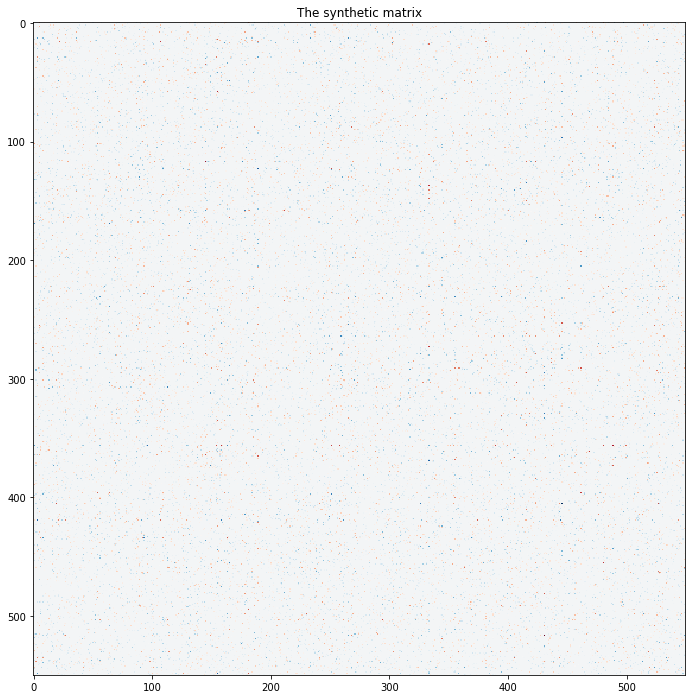

In [16]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, title="The synthetic matrix")
ax.imshow(R.todense(), cmap=plt.cm.RdBu, origin="upper")

print("Observed entries: %d / %d" % (R.nnz, np.prod(R.shape)))
plt.show()

# The IMC problem

The IMC problem is:
$$\begin{aligned}
    & \underset{W, H}{\text{miminize}}
      & & \sum_{(i,j)\in \Omega} l(p_{ij}, R_{ij})
          + \nu_W \sum_{m=1}^{d_1} \bigl\| W' e_m \bigr\|_2
          + \nu_H \sum_{m=1}^{d_2} \bigl\| H' e_m \bigr\|_2
          + \mu_W \bigl\| W \bigr\|_1
          + \mu_H \bigl\| H \bigr\|_1
            \,, \\
    & \text{with}
      & & p_{ij} = e_i'\, X W \, H' Y'\, e_j
      \,,
\end{aligned}$$
where $X \in \mathbb{R}^{n_1 \times d_1}$, $Y \in \mathbb{R}^{n_2 \times d_2}$,
$W \in \mathbb{R}^{d_1\times k}$ and $H \in \mathbb{R}^{d_2\times k}$.

### Quadratic Approximation
The target objective without regularization (holding $H$ fixed) is
$$ F(W; H)
    = \sum_{(i,j)\in \Omega}
        l(p_{ij}, R_{ij})
    \,, $$
in which $p = p(W) = (e_i' X W H' Y' e_j)_{(i,j)\in \Omega}$ are the current
predictions.

The Quadratic Approximation to $F$ around $W_0$ is
$$ Q(W; W_0)
    = F(W_0)
        + \nabla F(W_0)' \delta
        + \frac12 \delta' \nabla^2 F(W_0) \delta
    \,, $$
for $\delta = \mathtt{vec}(W - W_0)$. Now the gradient of $F$ w.r.t. vec-form of $W$ is
$$ \nabla F(W_0)
    = \mathtt{vec}\bigl(
        X' g Y H
    \bigr)
    \,, $$
with $g = g(W_0) = (l{'}_{p}(p(W_0)_{ij}, R_{ij}))_{(i,j)\in \Omega}$ is $\Omega$-sparse
matrix of first-order (gradient) data. For a matrix $D \in \mathbb{R}^{d_1 \times k}$
$$ \nabla^2F(W_0)\, \mathtt{vec}(D)
    = \mathtt{vec}\Bigl(
        X' \underbrace{\bigl\{h \odot (X D H'Y')\bigr\}}_{\Omega-\text{sparse}} YH
    \Bigr)
    \,, $$
where $h = h(W_0) = (l{''}_{pp}(p(W_0)_{ij}, R_{ij}))_{(i,j)\in \Omega}$ is
the $\Omega$-sparse matrix of the second order (hessian) values and $\odot$
is the element-wise matrix product.

The quadratic approximation with respect to $H$ around $H_0$ holding $W$ and $\Sigma$ fixed
is similar up to transposing $R$ and swapping $X \leftrightarrow Y$ and $W \leftrightarrow H$
in the above formulae.

**Note** that although the expressions for the gradient and the hessian-vector product presented above are identical to the fast operations in *section 3.1* of [H. Yu et al. (2014)](http://bigdata.ices.utexas.edu/publication/993/), the fomulae here have been derived independently. In fact, they are obvious products of simple block-matrix and **vech** algebra.

The implementation below is, however, completely original (although, nothing special).

#### Implementation details

To compute the gradient and the hessian-vector product we need the following
"elementary" operations:
* $\mathtt{Op}_d: D \mapsto (e_i' X D H'Y' e_j)_{(i, j)\in \Omega}$ -- a map
of some $\mathbb{R}^{d_1\times k}$ dense $D$ to a $\mathbb{R}^{n_1\times n_2}$
$\Omega$-sparse matrix $S$;
* $\mathtt{Op}_s: S \mapsto X'S YH$ mapping an $\mathbb{R}^{n_1\times n_2}$
$\Omega$-sparse $S$ to a $\mathbb{R}^{d_1\times k}$ dense matrix $D$.

The gradient becomes
$$ \nabla F(W_0)
    = \mathtt{vec}(\mathtt{Op}_s(g)) \,, $$
and the hessian-vector product transforms into
$$ \nabla^2 F(W_0)\,\mathtt{vec}(D)
    = \mathtt{vec}\bigl(\mathtt{Op}_s\bigl(h\odot \mathtt{Op}_d(D)\bigr)\bigr) \,. $$

In fact the predictions $p = p(W_0)$ also form an $\mathbb{R}^{n_1\times n_2}$
$\Omega$-matrix, that cam be computed by $p(W_0) = \mathtt{Op}_d(W_0)$. The
gradient $g(W_0)$ and hessian $h(W_0)$ statistics are also $\Omega$-sparse,
and can be computed by element-wise application of $l'_p$ and $l''_{pp}$
to $p$.

Similar formulae hold for $H$ with appropriate re-labellings and transpositions.


**Note** that the sparsity structure remains unchanged and the thin matrix $YH$
can be cached, since both $H$ and $Y$ fit in memory and $k < d_2 \ll n_2$.

In [17]:
# from sgimc import op_s, op_d

Define the objectives

The $l_2$ loss $l(p, t) = \frac12 (p-t)^2$.

In [18]:
from sgimc.qa_objective import QAObjectiveL2Loss

The log-loss $l(p, t) = \log \bigl(1 + e^{-t p}\bigr)$ for $t\in \{-1, +1\}$
and $p\in \mathbb{R}$.

\begin{align}
    \sigma(x)
        &= \frac1{1+e^{-x}}
        \,, \\
    \sigma'(x)
        &= -\frac{- e^{-x}}{(1+e^{-x})^2}
        = \frac{e^{-x}}{1+e^{-x}} \frac1{1+e^{-x}}
        = (1-\sigma(x))\,\sigma(x)
        \,, \\
    l(p, t)
        &= \log \bigl(1 + e^{-t p}\bigr)
         = \log \bigl(1 + e^{- \lvert p \rvert}\bigr)
         - \min\bigl\{t p, 0\bigr\}
        \,, \\
    l_p'(p, t)
        &= \frac{-t e^{-t p}}{1 + e^{-t p}}
         = -t (1 - \sigma(t p))
        \,, \\
      l_p''(p, t)
        &= (1 - \sigma(t p))\sigma(t p)
        = (1 - \sigma(p))\sigma(p)
        \,.
\end{align}

In [19]:
from sgimc.qa_objective import QAObjectiveLogLoss

Huber loss:
$$ l(x; \epsilon)
    = \begin{cases}
        \frac12 x^2
            & \text{if } \lvert x \rvert \leq \epsilon\,, \\
        \epsilon \bigl(\lvert x \rvert - \frac\epsilon2\bigr)
            & \text{otherwise}
    \end{cases}
    \,. $$
Therefore
$$ l_p'
    = \begin{cases}
        x   & \text{if } \lvert x \rvert \leq \epsilon\,, \\
        \epsilon \frac{x}{\lvert x \rvert}
            & \text{otherwise}
    \end{cases}
    \,, $$
and
$$ l_{pp}''
    = \begin{cases}
        1   & \text{if } \lvert x \rvert \leq \epsilon\,, \\
        0   & \text{otherwise}
    \end{cases}
    \,. $$

In [20]:
from sgimc.qa_objective import QAObjectiveHuberLoss

Choose the objective

In [21]:
if PROBLEM == "classification":
    QAObjectiveLoss = QAObjectiveLogLoss
else:
    QAObjectiveLoss = QAObjectiveL2Loss  # QAObjectiveHuberLoss

### Optimisation

Fix $H$ and consider the problem with respect to $W$:
$$\begin{aligned}
    & \underset{W \in \mathbb{R}^{d_1\times k}}{\text{miminize}}
      & & Q(W; W_0)
          + \sum_{m=1}^{d_1}
              \nu_m \bigl\| W' e_m \bigr\|_2
              + \mu_m \bigl\| W' e_m \bigr\|_1
              + \frac{\kappa_m}2 \bigl\| W' e_m \bigr\|_2^2
            \,.
\end{aligned}$$
Let's move to an equivalent problem by splitting the variables in
the objective, introducing linear consensus constraints and adding
$d_1$ ridge-like regularizers (augmenation)
$$\begin{aligned}
    & \underset{Z_m, \delta_m \in \mathbb{R}^{k\times 1}}{\text{miminize}}
      & & Q(\delta; W_0)
          + \sum_{m=1}^{d_1}
              \nu_m \bigl\| Z_m \bigr\|_2
              + \mu_m \bigl\| Z_m \bigr\|_1
              + \frac{\kappa_m}2 \bigl\| Z_m \bigr\|_2^2
          + \frac1{2\eta}
              \sum_{m=1}^{d_1} \bigl\| \delta_m - (Z_m - W_0'e_m) \bigr\|_2^2
          \,, \\
    & \text{subject to}
      & & Z_m - \delta_m = W_0' e_m\,, m=1 \ldots d_1
          \,,
\end{aligned}$$
with $\sum_{m=1}^{d_1} e_m \delta_m' = \delta$.

The objective is convex and the constraints are linear, which means that
Strong Duality holds for this problem. The lagrangian is
\begin{align}
    \mathcal{L}(Z_m, \delta_m; \lambda_m)
        &= F(W_0)
            + \nabla F(W_0)' \mathtt{vec}(\delta)
            + \frac12 \mathtt{vec}(\delta)' \nabla^2 F(W_0) \mathtt{vec}(\delta)
        \\
        & + \sum_{m=1}^{d_1}
              \nu_m \bigl\| Z_m \bigr\|_2
               + \mu_m \bigl\| Z_m \bigr\|_1
               + \frac{\kappa_m}2 \bigl\| Z_m \bigr\|_2^2
        \\
        & + \frac1\eta
              \sum_{m=1}^{d_1} \lambda_m'\bigl(\delta_m - (Z_m - W_0'e_m)\bigr)
          + \frac1{2\eta}
              \sum_{m=1}^{d_1} \bigl\| \delta_m - (Z_m - W_0'e_m) \bigr\|_2^2
        \,.
\end{align}
Note the following expressions
\begin{align}
    \sum_{m=1}^{d_1} \lambda_m'\bigl(\delta_m - (Z_m - W_0'e_m)\bigr)
        &= \mathtt{tr}\bigl((\delta - (Z - W_0))\Lambda'\bigr) \,,
        \\
    \sum_{m=1}^{d_1} \bigl\| \delta_m - (Z_m - W_0'e_m) \bigr\|_2^2
        &= \Bigl\| \delta - (Z - W_0) \Bigr\|_\text{F}^2 \,,
        \\
\end{align}
where $\Lambda = \sum_{m=1}^{d_1}e_m \lambda_m'$ and $Z = \sum_{m=1}^{d_1}e_m Z_m'$.

#### Sub-0

Consider the following subproblem ($\mathtt{Sub}_0^\text{QA}$):
$$\begin{aligned}
    & \underset{\delta \in \mathbb{R}^{d_1\times k}}{\text{miminize}}
      & & \nabla F(W_0)' \mathtt{vec}(\delta)
            + \frac12 \mathtt{vec}(\delta)' \nabla^2 F(W_0) \mathtt{vec}(\delta)
          \\
%     & & & + \frac1\eta
%               \mathtt{tr}\bigl((\delta - (Z - W_0))\Lambda'\bigr)
%           + \frac1{2\eta}
%               \Bigl\| \delta - (Z - W_0) \Bigr\|_\text{F}^2
    & & & + \frac1{2\eta}
              \Bigl\| \delta + W_0 - Z + \Lambda \Bigr\|_\text{F}^2
          - \frac1{2\eta} \| \Lambda \|_\text{F}^2
            \,.
\end{aligned}$$
The first-order-conditions for this convex problem w.r.t. $\mathtt{vec}(\delta)$
are
$$ \nabla F(W_0) + \nabla^2 F(W_0) \mathtt{vec}(\delta)
    + \frac1\eta
        \mathtt{vec}\bigl( \delta - (\underbrace{Z - W_0 - \Lambda}_{D}) \bigr)
    = 0 \,. $$
Since computing the inverse of the hessian is out of the quiestion, we use Conjugate
Gradient method to solve for $\delta$, because it queries the hessian
only through matrix-vector priducts, which are efficicnetly computable.


The map $\mathtt{Sub}_0^\text{QA}(D; \eta)$ returns the $\delta$ which satisfies
$$\Bigl( \nabla^2 F(W_0) + \frac1\eta I\Bigr)\mathtt{vec}(\delta)
    = \frac1\eta \mathtt{vec}\bigl(D \bigr) - \nabla F(W_0) \,. $$

In [22]:
from sgimc.algorithm.admm import sub_0_cg

Using a more comprehensive solver, like `L-BFGS` we can tackle the original
objective, instead of its Quadratic approximation.

Consider the subproblem ($\mathtt{Sub}_0^\text{Orig}$):
$$\begin{aligned}
    & \underset{W \in \mathbb{R}^{d_1\times k}}{\text{miminize}}
      & & F(W; H) + \frac1{2\eta}
              \Bigl\|W - Z + \Lambda \Bigr\|_\text{F}^2
          - \frac1{2\eta} \| \Lambda \|_\text{F}^2
            \,.
\end{aligned}$$
The L-BFGS requires the gradient of the final objective:
$$ \nabla F(W)
    + \frac1\eta
        \mathtt{vec}\bigl( W - (Z - \Lambda) \bigr) \,. $$


In [23]:
from sgimc.algorithm.admm import sub_0_lbfgs

#### Sub-m

The next set of subproblems is represented by the following problem ($\mathtt{Sub}_m$):
$$\begin{aligned}
    & \underset{Z_m \in \mathbb{R}^{k\times 1}}{\text{miminize}}
      & & \mu_m \bigl\| Z_m \bigr\|_1 + \nu_m \bigl\| Z_m \bigr\|_2
          + \frac{\kappa_m}2 \bigl\| Z_m \bigr\|_2^2
          \\
%     & & & + \frac1\eta \lambda_m'\bigl(\delta_m - (Z_m - W_0'e_m)\bigr)
%           + \frac1{2\eta} \bigl\| \delta_m - (Z_m - W_0'e_m) \bigr\|_2^2
    & & & + \frac1{2\eta} \bigl\| (\delta_m + W_0'e_m + \lambda_m) - Z_m\bigr\|_2^2
          - \frac1{2\eta} \| \lambda_m \|_2^2
            \,.
\end{aligned}$$
After a **lot of math** this problem admits a closed form solution:
$$ Z_m
    = \frac1{1 + \kappa_m \eta}
      \biggl(1 - \frac{\nu_m \eta}{\|S(V_m; \mu_m \eta)\|_2}\biggr)_+
        S(V_m; \mu_m \eta)
    \,, $$
where $V_m = \delta_m + W_0'e_m + \lambda_m$ and 
$$ S(u; \mu_m \eta)
    = \Bigl(\Bigl(1 - \frac{\mu_m \eta}{\lvert u_i \rvert}\Bigr)_+ u_i\Bigr)_{i=1}^k\,, $$
is the **soft_thresholding** operator.

The map $\mathtt{Sub}_m(D; \eta)$ returns $Z_m$ defined above.

In [24]:
from sgimc.algorithm.admm import sub_m

#### ADMM

Thus the QA-ADMM for $W$ around $W_0$ with $H$ fixed is the follwing
iterative procedure:
\begin{align}
    Z^{t+1}_m &= \mathtt{Sub}_m(W^t_m + \lambda^t_m) \,,\, m = 1\ldots d_1 \,,\\
    W^{t+1} &= \mathtt{Sub}_0(Z^{t+1} - W_0 - \Lambda^t) + W_0  \,,\\
    % W^{t+1} &= \mathtt{Sub}_0(Z^t - W_0 - \Lambda^t) + W_0  \,,\\
    % Z^{t+1}_m &= \mathtt{Sub}_m(W^{t+1}_m + \lambda^t_m) \,,\, m = 1\ldots d_1 \,,\\
    \Lambda^{t+1} &= \Lambda^t + (W^{t+1} - Z^{t+1})\,,\\
\end{align}
where $W^{t+1}_m$ is the $m$-th row of $W^{t+1}$, $Z^{t+1}_m$ is the
$m$-th row of $Z^{t+1}$ and $\lambda_m$ is the $m$-th row of $\Lambda$.
These iterations necessarily converge to a fixed point, which is the
solution of the original optimisation problem. If stopped early, the
current values of $W^t$ and $Z^t$ would be close to each other, however
$Z^t$ would be sparse and $W^t$ -- dense.

Note that we can also consider ADMM with a linear approximation of $F$
w.r.t. $W$ at $W_0$, instead of the quadratic (LA-ADMM). This way the algorithm
reduces to prox-gradient descent with step $\eta$. Although it does not utilize
the second order infromation, it can be fused with Nesterov's Accelerated
gradient.

In [25]:
from sgimc.algorithm import admm_step

def step_qaadmm(X, W, Y, H, R, C, eta, method="l-bfgs", sparse=True,
                n_iterations=50, rtol=1e-5, atol=1e-8, n_threads=4):

    b_hessian = method in ("cg",)

    Obj = QAObjectiveLoss(X, W, Y, H, R, hessian=b_hessian,
                          n_threads=n_threads)

    return admm_step(Obj, W, C, eta, sparse=sparse, method=method,
                     n_iterations=n_iterations, rtol=rtol, atol=atol)

In [26]:
from sgimc.algorithm.decoupled import step as decoupled_step

def step_decoupled(X, W, Y, H, R, C, eta,
                   rtol=1e-5, atol=1e-8, n_threads=4):

    Obj = QAObjectiveLoss(X, W, Y, H, R, hessian=False,
                          n_threads=n_threads)

    return decoupled_step(Obj, W, C, eta, rtol=rtol, atol=atol)

Ad-hoc procedure. No guarantees for convergence.

In [27]:
# def step_adhoc(X, W, Y, H, R, C, eta, rtol=1e-5, atol=1e-8, n_threads=4):
#     Obj = QAObjectiveLoss(X, W, Y, H, R, hessian=True,
#                           n_threads=n_threads)

#     delta = sub_0_cg(np.zeros_like(W), Obj, eta=eta, tol=1e-8)
#     return sub_m(delta + W, *C, eta=eta)

In [28]:
# def QA_argmin(D, Obj, tol=1e-8):

#     # set up the CG arguments
#     x = D.reshape(-1).copy()
#     b = - Obj.grad().reshape(-1)
#     Ax = lambda x: Obj.hess_v(x.reshape(D.shape)).reshape(-1)

#     n_iter = simple_cg(Ax, b, x, tol=tol)
#     return x.reshape(D.shape)

Thus Sparse Group IMC via QA-ADMM is the follwing iterative procedure:
* $W^{t+1} = \mathtt{ADMM}\bigl(W^t; H^t\bigr)$,
* $H^{t+1} = \mathtt{ADMM}\bigl(H^t; W^{t+1}\bigr)$,

until convergence.

In [29]:
from sgimc import imc_descent

The loss information: value and regularization on the train data and value of the full matrix.

In [30]:
from sgimc.utils import performance

### Illustration

In [31]:
step_fn = step_qaadmm
# step_fn = step_decoupled

$$\bigl(C_\mathtt{lasso}, C_\mathtt{group}, C_\mathtt{ridge}\bigr) = C \,.$$
It seems that it must hold $C_\mathtt{lasso} > C_\mathtt{group}$ so that
individual sparsity preceeds group sparsity.

In [32]:
if PROBLEM == "classification":
    C = 1e0, 1e-1, 1e-3
    eta = 1e0
else:
    # C = 2e-5, 2e-3, 0
    C = 2e-3, 2e-4, 1e-4  # 1e-2
    eta = 1e1

In [33]:
if step_fn == step_decoupled:
    eta = 1e-3

Let's see how the feature coefficients look like.

In [34]:
from sgimc.utils import plot_WH, plot_loss

Initialization

In [35]:
K = 10  # n_rank
# K = n_rank

W_0 = random_state.normal(size=(X.shape[1], K))
H_0 = random_state.normal(size=(Y.shape[1], K))

# W_0 = W_ideal.copy() # + random_state.normal(scale=0.1, size=(X.shape[1], K))
# H_0 = H_ideal.copy() # + random_state.normal(scale=0.1, size=(Y.shape[1], K))

Now in this experiment the ideal solution is a unit matrix stacked atop a zero martix.

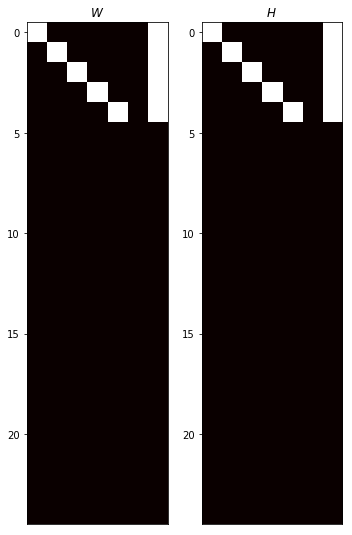

The loss on the initial guess is:
1.549e-34 + 2.250e-02 -- partial matrix
0.000e+00 -- full matrix
score 0.0000


In [36]:
plot_WH(W_ideal, H_ideal)

loss_arr, exp_type, norm_type = performance(X, W_ideal,
                                            Y, H_ideal,
                                            R, C, R_full,
                                            QAObjectiveLoss)

print("The loss on the initial guess is:")
print("%.3e + %.3e -- partial matrix" % (loss_arr[0, -1], loss_arr[1, -1]))
print("%.3e -- full matrix" % loss_arr[3, -1])
print("score %.4f" % loss_arr[2, -1])

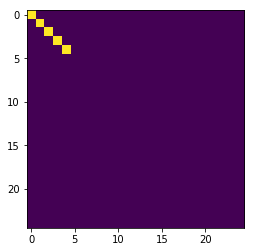

In [37]:
plt.imshow(np.dot(W_ideal, H_ideal.T))

The initial guess is:

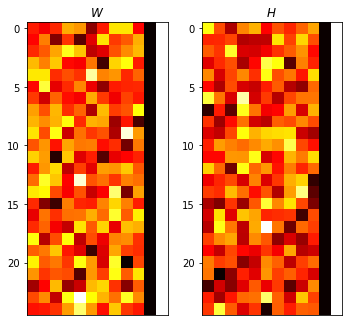

The loss on the initial guess is:
6.189e+02 + 8.535e-01 -- partial matrix
6.296e+03 -- full matrix
score 0.0416


In [38]:
plot_WH(W_0, H_0)

loss_arr, exp_type, norm_type = performance(X, W_0,
                                            Y, H_0,
                                            R, C, R_full,
                                            QAObjectiveLoss)

print("The loss on the initial guess is:")
print("%.3e + %.3e -- partial matrix" % (loss_arr[0, -1], loss_arr[1, -1]))
print("%.3e -- full matrix" % loss_arr[3, -1])
print("score %.4f" % loss_arr[2, -1])

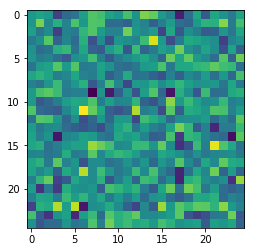

In [39]:
plt.imshow(np.dot(W_0, H_0.T))

Run!

In [40]:
W, H = W_0.copy(), H_0.copy()

In [41]:
W, H = imc_descent(
    X, W, Y, H, R, C, step_fn, eta=eta,
    n_iterations=1000, rtol=1e-4, atol=1e-7,
    verbose=True, return_history=True)

 23%|██▎       | 229/1000 [00:22<01:15, 10.19it/s]


Inspect

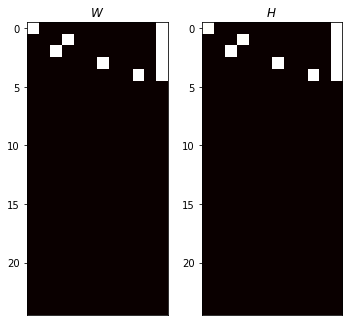

The loss on the final estimates is:
7.220e-05 + 2.236e-02 -- partial matrix
7.201e-04 -- full matrix
score 0.0000


In [42]:
plot_WH(abs(W[..., -1]), abs(H[..., -1]))

loss_arr, exp_type, norm_type = performance(X, W, Y, H, R, C, R_full,
                                            QAObjectiveLoss)

print("The loss on the final estimates is:")
print("%.3e + %.3e -- partial matrix" % (loss_arr[0, -1], loss_arr[1, -1]))
print("%.3e -- full matrix" % loss_arr[3, -1])
print("score %.4f" % loss_arr[2, -1])

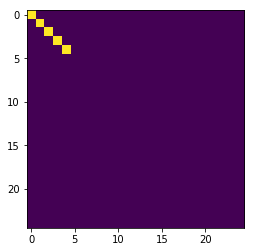

In [43]:
plt.imshow(np.dot(W[..., -1], H[..., -1].T))

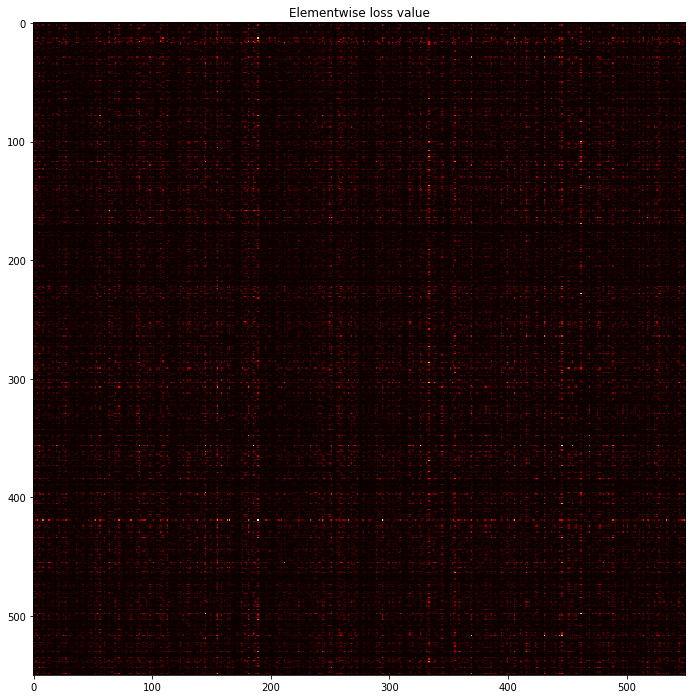

In [44]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, title="Elementwise loss value")
R_hat = np.dot(np.dot(X, W[..., -1]), np.dot(Y, H[..., -1]).T)
ax.imshow(QAObjectiveLoss.v_func(R_hat, R_full), cmap=plt.cm.hot, origin="upper")
plt.show()

In [45]:
print(str(np.array(["#", "."])[np.isclose(W[..., -1], 0)*1]).replace("' '", ""))

[['#.........']
 ['...#......']
 ['..#.......']
 ['......#...']
 ['.........#']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']]


In [46]:
print(str(np.array(["#", "."])[np.isclose(H[..., -1], 0)*1]).replace("' '", ""))

[['#.........']
 ['...#......']
 ['..#.......']
 ['......#...']
 ['.........#']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']
 ['..........']]


In [47]:
np.linalg.norm(W[..., -1], 2, axis=-1)

array([ 0.99175369,  0.99185164,  0.98818499,  0.99001274,  0.98935945,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [48]:
np.linalg.norm(H[..., -1], 2, axis=-1)

array([ 0.99435157,  0.99393579,  1.00056854,  0.99842944,  0.99936457,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

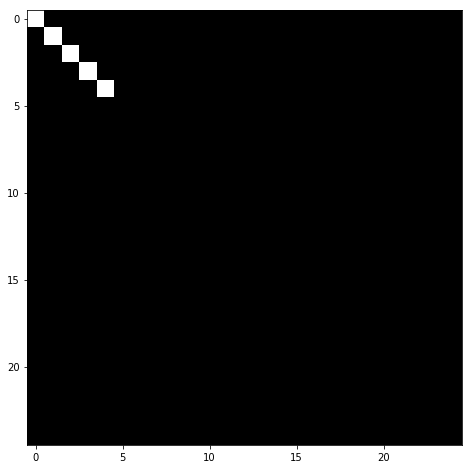

In [49]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.imshow(~ np.isclose(np.dot(W[..., -1], H[..., -1].T),
                       np.dot(W_ideal, H_ideal.T)),
          cmap=plt.cm.binary_r)
plt.show()

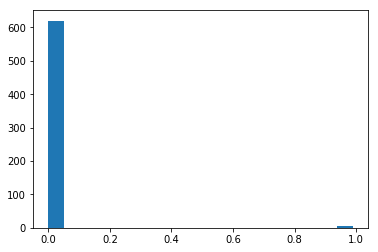

In [50]:
plt.hist(abs(np.dot(W[..., -1], H[..., -1].T)).reshape(-1), bins=20) ;

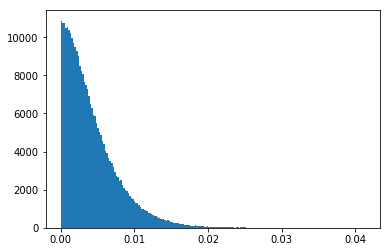

In [51]:
plt.hist(abs(R_hat).reshape(-1), bins=200) ;

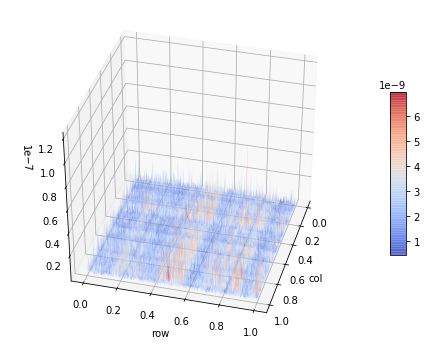

In [52]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d', xlabel="col", ylabel="row")

ZZ = QAObjectiveLoss.v_func(R_hat, R_full)
mesh_ = np.meshgrid(*[np.linspace(0, 1, num=n) for n in ZZ.shape[::-1]])

surf = ax.plot_surface(*mesh_, ZZ, alpha=0.5, lw=0, antialiased=True,
                       cmap=plt.cm.coolwarm)

fig.colorbar(surf, shrink=0.5, aspect=10)

ax.view_init(37, 15)


In [53]:
ZZ[~mask].std()

4.3084576911757786e-09

In [54]:
ZZ[mask].std()

4.2925064982414122e-09

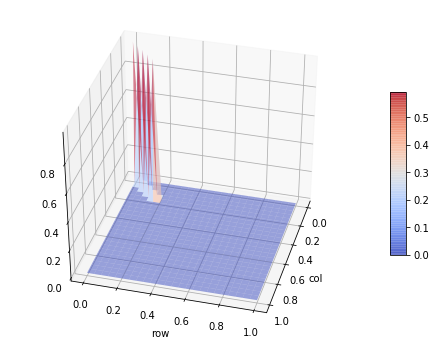

In [55]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d', xlabel="col", ylabel="row")

ZZ = np.dot(W[..., -1], H[..., -1].T)
mesh_ = np.meshgrid(*[np.linspace(0, 1, num=n) for n in ZZ.shape[::-1]])

surf = ax.plot_surface(*mesh_, ZZ, alpha=0.5, lw=0, antialiased=True,
                       cmap=plt.cm.coolwarm)

fig.colorbar(surf, shrink=0.5, aspect=10)

ax.view_init(37, 15)


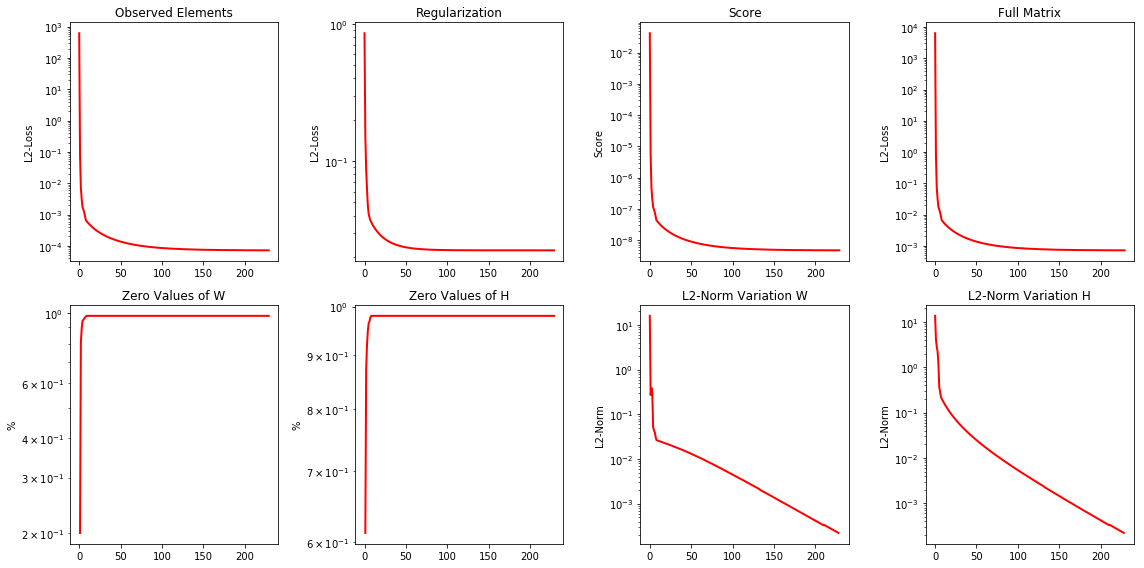

In [56]:
plot_loss(loss_arr, exp_type, norm_type,
          fig_size=4, max_cols=4, yscale="log")

<hr/>